In [1]:
!pip install pyreadr -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 13.8 MB/s eta 0:00:00


In [2]:
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, Dense,Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

2025-06-04 18:53:47.990076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749063228.316717      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749063228.437593      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Only Training data is used

df_FaultFree = pyreadr.read_r(r'/kaggle/input/tennessee-eastman-process-simulation-dataset/TEP_FaultFree_Training.RData')['fault_free_training']
df_Faulty = pyreadr.read_r(r'/kaggle/input/tennessee-eastman-process-simulation-dataset/TEP_Faulty_Training.RData')['faulty_training']

In [4]:
DF = pd.concat([df_FaultFree,df_Faulty]) # Join both fault free and faulty dataset
DF.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


# Scale the dataset

In [5]:
# Initialize a StandardScaler object
sc = StandardScaler()

# Filter the DataFrame to only include data from the first simulation run
data = DF[DF['faultNumber']==0]
# Select the rows from the reduced dataset that have faultNumber equal to 0, and extract the feature values
fault_free = data[(data['faultNumber'] == 0)].iloc[:, 3:]

# Fit the StandardScaler object to the feature values of the fault-free data
sc.fit(fault_free)


StandardScaler()

In [6]:
reduced_data = DF[(DF['simulationRun'] >= 1) & (DF['simulationRun'] <= 50)]
reduced_data = reduced_data[reduced_data['faultNumber'] != 3]
reduced_data = reduced_data[reduced_data['faultNumber'] != 9]
reduced_data = reduced_data[reduced_data['faultNumber'] != 15]

X = sc.transform(reduced_data[reduced_data['sample']>20].iloc[:,3:])
Y = reduced_data[reduced_data['sample']>20]['faultNumber'].values

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
enc.fit(Y.reshape(-1, 1))

Y_enc = enc.transform(Y.reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y_enc, test_size=0.2, random_state=42)

In [8]:
x_train.shape

(345600, 52)

# PCA and ICA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])


In [ ]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=2, random_state=42)
X_ica = ica.fit_transform(X_scaled)


df_ica = pd.DataFrame(X_ica, columns=['ICA1', 'ICA2'])


# Train the Neural Network algorithms

In [55]:
from keras.layers import Input, Dense
from keras.models import Model

# Define input layer
inputs = Input(shape=(x_train.shape[1],))

# Define hidden layer with 16 nodes and ReLU activation function
hidden_layer = Dense(100, activation='relu')(inputs)
hidden_layer = Dense(100, activation='relu')(hidden_layer)
# Define output layer with softmax activation function for binary classification
outputs = Dense(y_train.shape[1], activation='softmax')(hidden_layer)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with binary cross-entropy loss function and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 52)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │           5,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 18)                  │           1,818 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,218 (67.26 KB)

 Trainable params: 17,218 (67.26 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
from keras.callbacks import EarlyStopping


# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(x_train, y_train, epochs=200, batch_size=256, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

Epoch 1/200
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6941 - loss: 1.0082 - val_accuracy: 0.8975 - val_loss: 0.3546
Epoch 2/200
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9081 - loss: 0.3205 - val_accuracy: 0.9187 - val_loss: 0.2931
Epoch 3/200
 473/1350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9253 - loss: 0.2567

KeyboardInterrupt: 

# Intermediate Model

In [137]:
from tensorflow.keras import Model

intermediate_model = Model(inputs=model.input,outputs=model.layers[-2].output)
intermediate_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 52)]              0         
                                                                 
 dense_28 (Dense)            (None, 100)               5300      
                                                                 
 dense_29 (Dense)            (None, 100)               10100     
                                                                 
Total params: 15,400
Trainable params: 15,400
Non-trainable params: 0
_________________________________________________________________


In [138]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

x_post_ann = intermediate_model.predict(x_train[::10])
y_rf_train = enc.inverse_transform(y_train[::10])



1080/1080 [==============================] - 1s 1ms/step


In [139]:
rf.fit(x_post_ann, y_rf_train)

C:\Users\Asus\AppData\Local\Temp\ipykernel_10156\1192949553.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_post_ann, y_rf_train)


RandomForestClassifier()

In [140]:
x_test_rf = intermediate_model.predict(x_test)
y_test_rf = enc.inverse_transform(y_test)

2700/2700 [==============================] - 4s 1ms/step


In [141]:
y_pred = rf.predict(x_test_rf)

# Evaluate the trained model

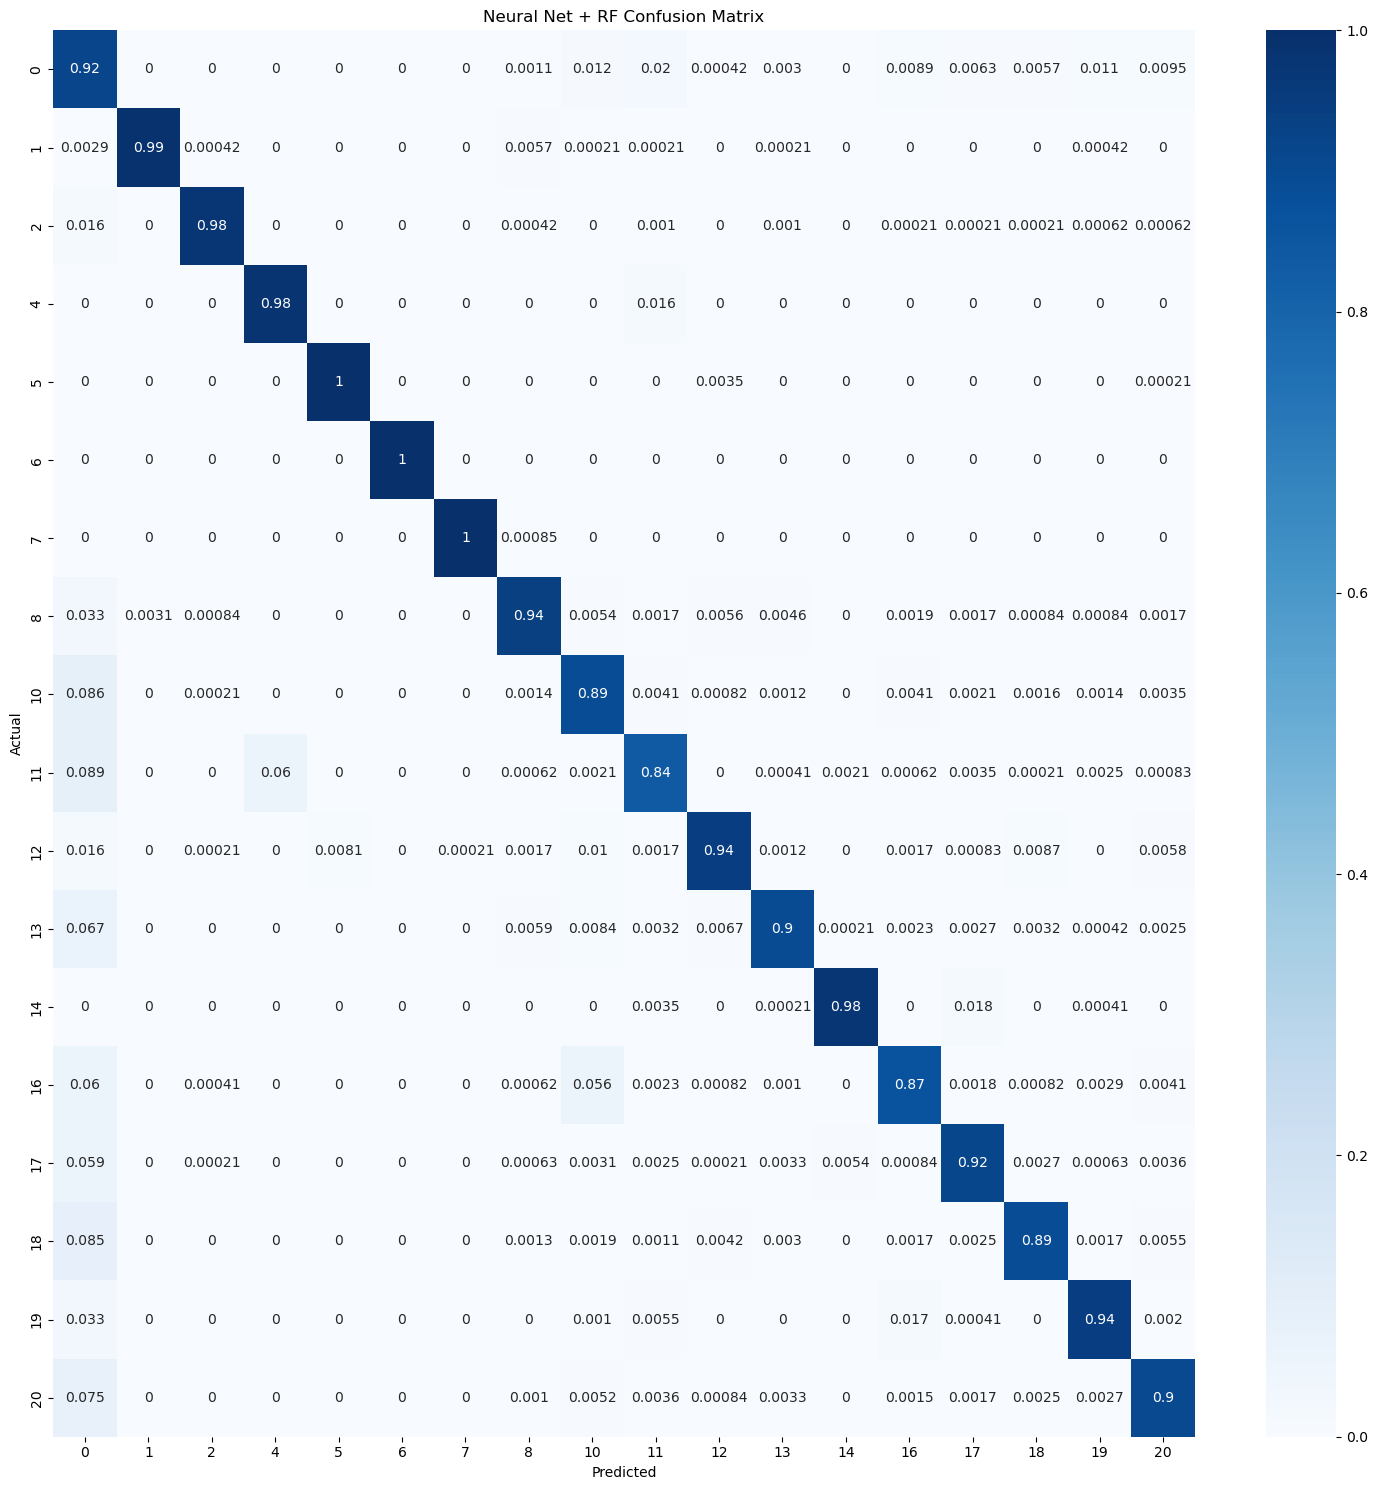

Neural Net + RF accuracy_score: 0.9379166666666666


In [142]:
# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred,normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues',ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels([str(x) for x in range(0,21) if x not in [3,9,15]])
    ax.set_yticklabels([str(x) for x in range(0,21) if x not in [3,9,15]])
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_test_rf, y_pred, 'Neural Net + RF Confusion Matrix')
print("Neural Net + RF accuracy_score:", accuracy_score(y_test_rf, y_pred))

# Gated Reccurent Unit 

In [37]:
reduced_data = DF[(DF['simulationRun'] >= 1) & (DF['simulationRun'] <= 50)]
reduced_data = reduced_data[reduced_data['faultNumber'] != 3]
reduced_data = reduced_data[reduced_data['faultNumber'] != 9]
reduced_data = reduced_data[reduced_data['faultNumber'] != 15]

X = sc.transform(reduced_data[reduced_data['sample']>20].iloc[:,3:])
Y = reduced_data[reduced_data['sample']>20]['faultNumber'].values

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
enc.fit(Y.reshape(-1, 1))

Y_enc = enc.transform(Y.reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [41]:
# Since GRU is sequential model, we divide row data into 
# time_steps and num_sequences

time_steps = 100
features = 52
num_sequences = X.shape[0]//time_steps
n_classes = 18


# Reshaping the data in format : (num_sequences, time_steps, features)
x_seq = X[:num_sequences * time_steps]  # trim excess
x_seq = x_seq.reshape((num_sequences, time_steps, features))

y = Y_enc[:num_sequences * time_steps]
y_seq = y.reshape((num_sequences, time_steps, n_classes))
y_seq = y_seq[:, -1, :]  # Use last timestep’s label as the sequence label

In [48]:
y_train_seq.shape

(864, 100, 52)

## Model

In [49]:
#split
x_train_seq, x_test_seq , y_train_seq, y_test_seq = train_test_split(x_seq, y_seq, test_size=0.2, random_state=42)

# Instantiating Model

model = Sequential([
    GRU(128, return_sequences=True, input_shape=(time_steps, features)),
    Dropout(0.3),
    GRU(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Train 
model.fit(x_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.1)


# prediction
y_pred = model.predict(x_test_seq)


#Evaluate
loss, acc = model.evaluate(x_test_seq, y_test_seq)
print(f"Test Accuracy: {acc:.2f}")

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.3335 - loss: 2.3302 - val_accuracy: 0.7312 - val_loss: 0.9752
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.7044 - loss: 0.9703 - val_accuracy: 0.8382 - val_loss: 0.4157
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.8411 - loss: 0.4818 - val_accuracy: 0.8902 - val_loss: 0.2835
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.8943 - loss: 0.2968 - val_accuracy: 0.8988 - val_loss: 0.2196
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.9140 - loss: 0.2309 - val_accuracy: 0.9595 - val_loss: 0.1301
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9438 - loss: 0.1623 - val_accuracy: 0.9711 - val_loss: 0.0955
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.9672 - loss: 0.1108 - val_accuracy: 0.9769 - val_loss: 0.0816
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.9807 - loss: 0.0686 - val_accu

## Evaluate the Model

In [58]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_seq, axis=1)

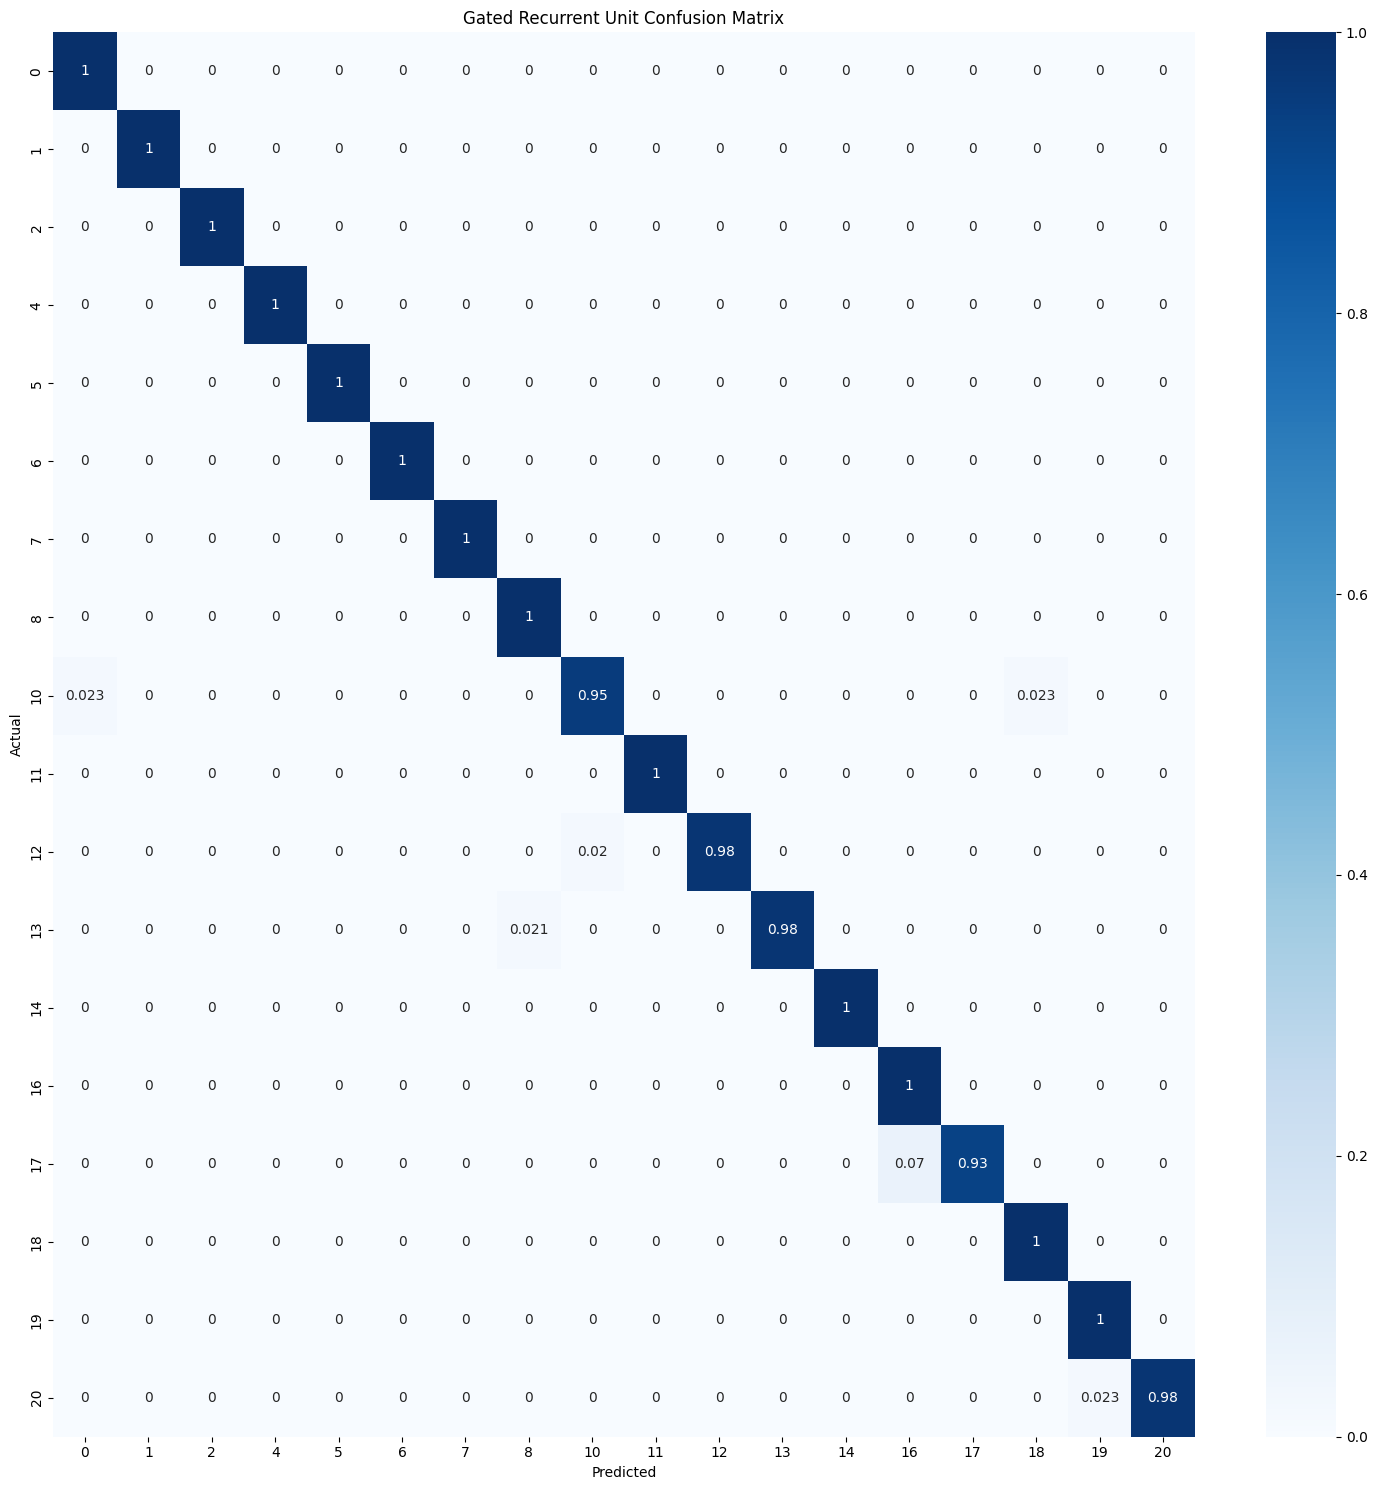

Gated Recurrent Unit accuracy_score: 0.9907407407407407


In [61]:
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred,normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues',ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels([str(x) for x in range(0,21) if x not in [3,9,15]])
    ax.set_yticklabels([str(x) for x in range(0,21) if x not in [3,9,15]])
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true_labels, y_pred_labels, 'Gated Recurrent Unit Confusion Matrix')
print("Gated Recurrent Unit accuracy_score:", accuracy_score(y_true_labels, y_pred_labels))

# Hybrid model :- GRU and XgBoost

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [8]:
# Since GRU is sequential model, we divide row data into 
# time_steps and num_sequences

time_steps = 100
features = 52
num_sequences = X.shape[0]//time_steps
n_classes = 18


# Reshaping the data in format : (num_sequences, time_steps, features)
x_seq = X[:num_sequences * time_steps]  # trim excess
x_seq = x_seq.reshape((num_sequences, time_steps, features))

y = Y_enc[:num_sequences * time_steps]
y_seq = y.reshape((num_sequences, time_steps, n_classes))
y_seq = y_seq[:, -1, :]  # Use last timestep’s label as the sequence label

In [14]:
#split
x_train_seq, x_test_seq , y_train_seq, y_test_seq = train_test_split(x_seq, y_seq, test_size=0.2, random_state=42)

# Instantiating Model
input_layer = Input(shape=(time_steps, features))

x = GRU(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = GRU(64)(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(n_classes, activation='softmax')(x)



gru_model = Model(inputs=input_layer, outputs=output_layer)



gru_model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

#Train 
gru_model.fit(x_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(x_test_seq, y_test_seq))


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.3639 - loss: 2.2383 - val_accuracy: 0.6771 - val_loss: 1.0072
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.7412 - loss: 0.8713 - val_accuracy: 0.8160 - val_loss: 0.4980
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.8413 - loss: 0.4590 - val_accuracy: 0.9039 - val_loss: 0.3135
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.9073 - loss: 0.2822 - val_accuracy: 0.9502 - val_loss: 0.2087
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.9570 - loss: 0.1615 - val_accuracy: 0.9734 - val_loss: 0.1312
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9822 - loss: 0.0804 - val_accuracy: 0.9850 - val_loss: 0.0821
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.9798 - loss: 0.0702 - val_accuracy: 0.9803 - val_loss: 0.0746
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.9939 - loss: 0

In [18]:
_ = gru_model.predict(x_train_seq[:1])

feature_extractor = Model(inputs=gru_model.input, outputs=gru_model.layers[-2].output)

x_train_features = feature_extractor.predict(x_train_seq)
x_test_features = feature_extractor.predict(x_test_seq)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [16]:
# Extracting the features from GRUs

y_train_labels = np.argmax(y_train_seq, axis=1)
y_test_labels = np.argmax(y_test_seq, axis=1)

In [19]:
# fitting on Xgboost

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=n_classes,
    eval_metric='mlogloss',
    use_label_encoder=False
)

xgb_clf.fit(x_train_features, y_train_labels)

y_pred = xgb_clf.predict(x_test_features)
acc = accuracy_score(y_test_labels, y_pred)
print(f"Validation Accuracy of GRU + XGBoost Hybrid: {acc:.4f}")

Validation Accuracy of GRU + XGBoost Hybrid: 0.9826


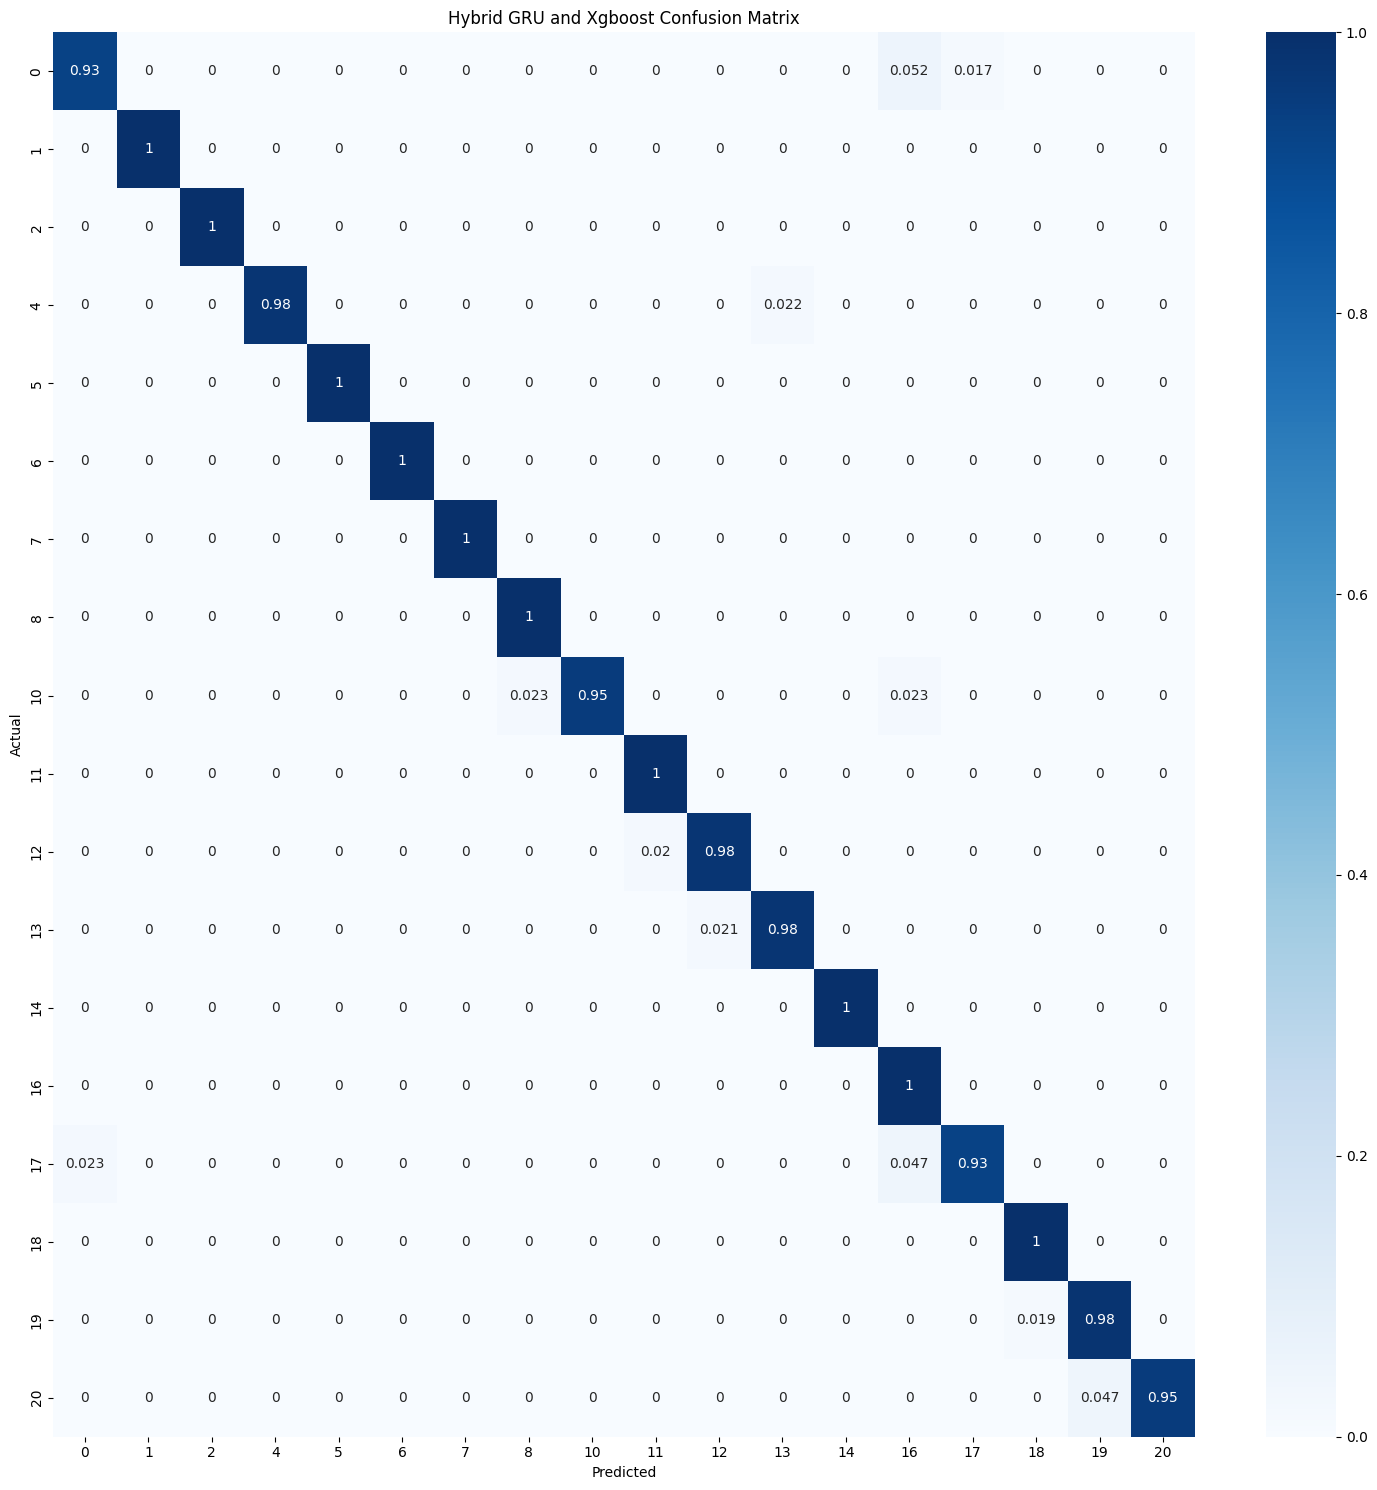

Hybrid GRU and Xgboost accuracy_score: 0.9826388888888888


In [20]:
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred,normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues',ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels([str(x) for x in range(0,21) if x not in [3,9,15]])
    ax.set_yticklabels([str(x) for x in range(0,21) if x not in [3,9,15]])
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_test_labels, y_pred, 'Hybrid GRU and Xgboost Confusion Matrix')
print("Hybrid GRU and Xgboost accuracy_score:", acc)

# Realtime Fault Prediction

In [21]:
for F_num in range(0,21):
    df_new= DF[(DF['faultNumber']==F_num) & (DF['simulationRun']==2)]
    x_new = df_new.iloc[:,3:]
    x_new = sc.transform(x_new)

    x_nn = intermediate_model.predict(x_new,verbose=0)
    y_pred = rf.predict(x_nn)
    y_proba = np.max(rf.predict_proba(x_nn),axis=1)

    f, ax = plt.subplots(figsize=(10,3))
    
    sns.scatterplot(x=df_new['sample'],y=y_pred,hue=y_proba,palette="coolwarm",s=80,alpha=0.4)
    
    plt.axvline(20,c='r',alpha=0.8,linestyle ='--')
    plt.axhline(F_num,c='cyan',alpha=0.8,label='Actual Fault',linestyle ='--')
    plt.legend(bbox_to_anchor=(1.5, 1.05))
    plt.ylabel('Predicted fault class')
    plt.title(f'Actual fault-{F_num}')
    plt.show()

NameError: name 'intermediate_model' is not defined

# Obtain SIngle Accuracy Score matrice

In [147]:
Accuracy=[]
for Fnum in [x for x in range(0,21) if x not in [3,9,15]]:

    temp_df = DF[ (DF['faultNumber']==Fnum) & (DF['sample']>20) & (DF['simulationRun']==np.random.randint(1,500))]
    X_faulty = sc.transform(temp_df.iloc[:,3:])
    y_true = temp_df['faultNumber']
    
    x_nn = intermediate_model.predict(X_faulty,verbose=0)
    y_pred = rf.predict(x_nn)
    
    
    acc = accuracy_score(y_true, y_pred)
    print(f'The accuracy for Fault_num={Fnum} is {acc}')
    
    Accuracy.append(acc)
print("#"*20)
print(f'The overall accuracy for Neural Net + RF is {np.mean(Accuracy)}')

The accuracy for Fault_num=0 is 0.94375
The accuracy for Fault_num=1 is 0.9833333333333333
The accuracy for Fault_num=2 is 0.9833333333333333
The accuracy for Fault_num=4 is 0.9770833333333333
The accuracy for Fault_num=5 is 0.9979166666666667
The accuracy for Fault_num=6 is 1.0
The accuracy for Fault_num=7 is 1.0
The accuracy for Fault_num=8 is 0.9104166666666667
The accuracy for Fault_num=10 is 0.89375
The accuracy for Fault_num=11 is 0.8666666666666667
The accuracy for Fault_num=12 is 0.9625
The accuracy for Fault_num=13 is 0.8833333333333333
The accuracy for Fault_num=14 is 0.9729166666666667
The accuracy for Fault_num=16 is 0.8875
The accuracy for Fault_num=17 is 0.925
The accuracy for Fault_num=18 is 0.8270833333333333
The accuracy for Fault_num=19 is 0.9458333333333333
The accuracy for Fault_num=20 is 0.8916666666666667
####################
The overall accuracy for Neural Net + RF is 0.9362268518518518
